## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import torch
from matplotlib import pyplot as plt
%matplotlib inline 

import numpy as np
import math
import cv2

from tools.functions import *

import warnings
warnings.filterwarnings('ignore')

## <span style='color:#ff5f27'> 💽 Original Photo

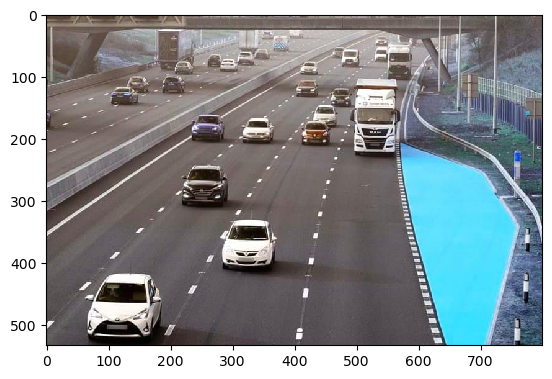

In [2]:
image = cv2.imread('../data/traffic.jpg')

plt.imshow(image, interpolation='nearest')
plt.show()

## <span style='color:#ff5f27'> 🔮 Predict Photo

In [3]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5n')

Using cache found in /Users/maxzhytnikov/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-1-17 Python-3.9.13 torch-1.13.1 CPU

Fusing layers... 
YOLOv5n summary: 213 layers, 1867405 parameters, 0 gradients
Adding AutoShape... 


image 1/1: 533x800 16 cars, 2 buss, 1 truck
Speed: 5.3ms pre-process, 56.9ms inference, 1.7ms NMS per image at shape (1, 3, 448, 640)


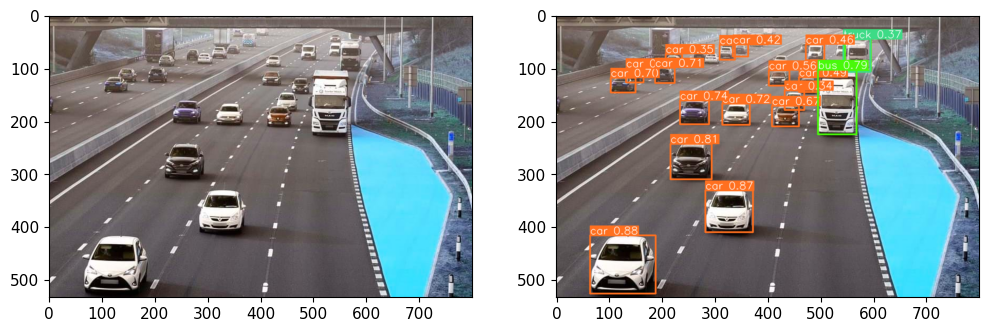

In [4]:
%matplotlib inline 

fig,ax = plt.subplots(1,2,figsize=(12,6))

image_copy = image.copy()
ax[0].imshow(image_copy)

results = model(image_copy)
results.print()

ax[1].imshow(np.squeeze(results.render()))

plt.show()

# <span style='color:#ff5f27'> 🩻 Bounding Boxes 

Saved 1 image to runs/detect/exp325
Saved results to runs/detect/exp325



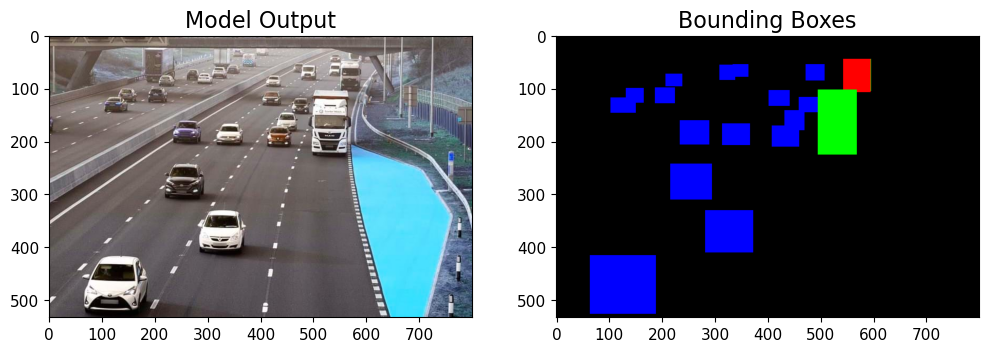

In [5]:
results_list = results.crop()

bounding_boxes = np.array([annot['box'] for annot in results_list])
labels = np.array([annot['label'].split()[0] for annot in results_list])

image_bounding_boxes = retrieve_bounding_boxes(image, bounding_boxes, labels)

fig, ax = plt.subplots(1, 2, figsize=(12,4))

ax[0].imshow(image)
ax[1].imshow(image_bounding_boxes)

ax[0].set_title('Model Output', fontsize=16)
ax[1].set_title('Bounding Boxes', fontsize=16)

plt.show()

# <span style='color:#ff5f27'> 🦅 Bird View

In [6]:
# Get image shapes
IMAGE_H, IMAGE_W = image.shape[:2]

points1 = np.array([
    [0, IMAGE_H],              # Bottom Left
    [250, 250],                # Top Left 
    [580, 250],                # Top Right
    [650, IMAGE_H]             # Bottom Right
])

points2 = np.array([
    [0, IMAGE_H],              # Bottom Left
    [int(IMAGE_W / 2), 100],   # Top Left 
    [580, 100],                # Top Right
    [650, IMAGE_H]             # Bottom Right
])

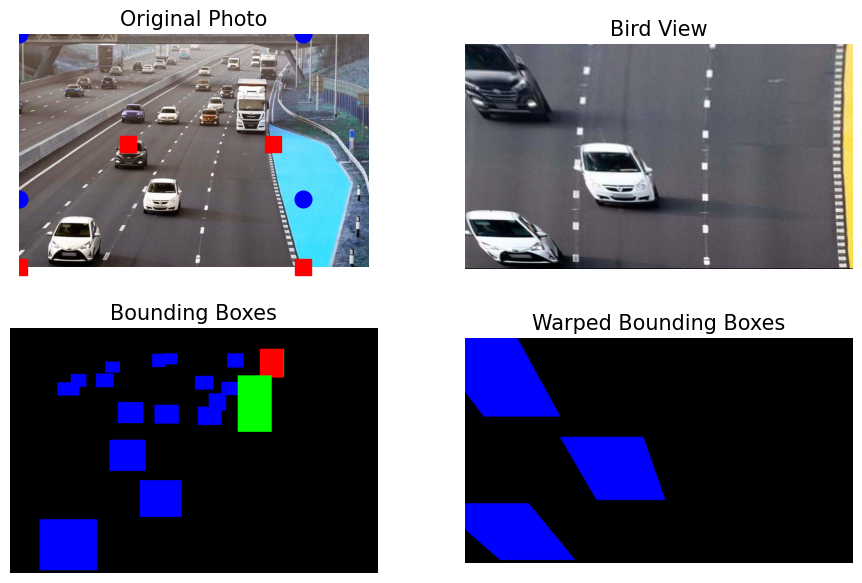

In [7]:
matrix, image_warped, image_warped_bb, rect, dst = bird_view_transformation_skewed(
    image,
    points1,
    image_bounding_boxes
)

show_bird_view(image, image_bounding_boxes, image_warped, image_warped_bb, rect, dst)

# <span style='color:#ff5f27'> 🧙🏼‍♂️ Bounding Box Transformation</span>

- Filter bounding boxes located in required poligon.

- Detect a centre of each Bounding Box.
    
- Find a vector of movement.

- Find an angle between x-axis and vector.

- Define default bounding box shapes for each class (car, truck(length = len(car) * 3), bus(length = len(car) * 3))).

- Build a rectangle depending on object class, its moving vector and center point.
    
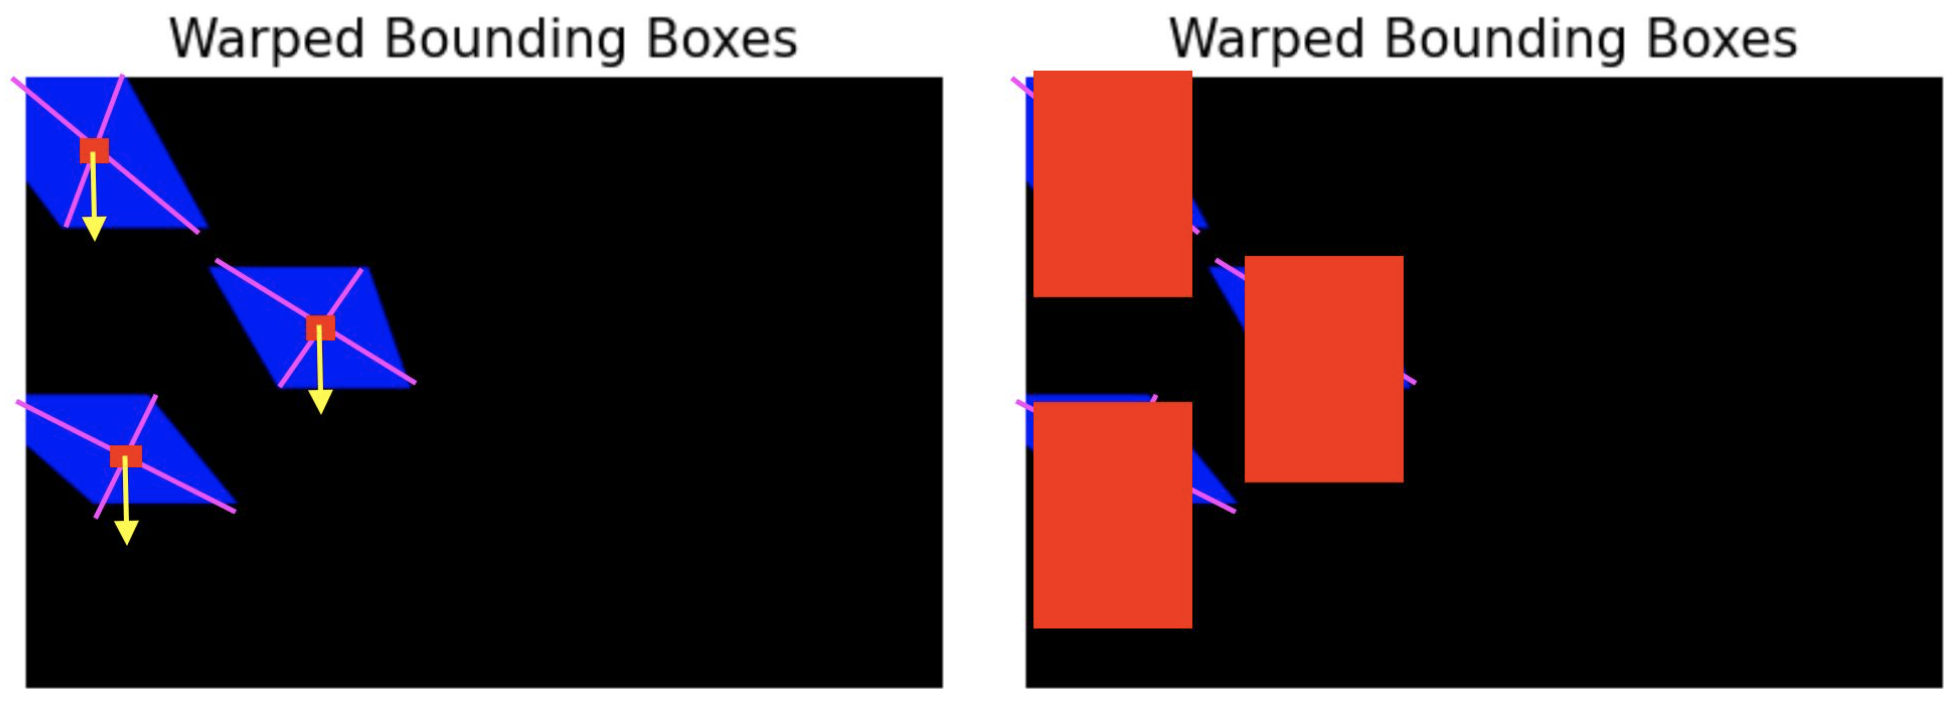

## <span style='color:#ff5f27'> 👮🏻‍♂️ Filtering Boxes</span>

In [8]:
bounding_boxes = np.array([box['box'] for box in results.crop()])

mask = [filter_point(box[2:], points1) for box in bounding_boxes]

bounding_boxes_filtered = bounding_boxes[mask]
bounding_boxes_filtered

Saved 1 image to runs/detect/exp326
Saved results to runs/detect/exp326



array([[     216.99,      243.62,      294.21,      310.25],
       [     282.92,       331.1,      372.54,      410.08],
       [     64.633,      416.33,      188.94,      526.26]], dtype=float32)

## <span style='color:#ff5f27'> 🕵🏼 Detecting a centre of each Bounding Box</span>

In [9]:
bounding_boxes_centres = [get_box_centre(box_coords) for box_coords in bounding_boxes_filtered]
bounding_boxes_centres

[(255.60035705566406, 276.93463134765625),
 (327.72808837890625, 370.59014892578125),
 (126.78897094726562, 471.29559326171875)]

In [10]:
bounding_boxes_centres_transformed = cv2.perspectiveTransform(
    np.array([[[*centre] for centre in bounding_boxes_centres]]),
    matrix
)
bounding_boxes_centres_transformed

array([[[     52.924,      64.532],
        [     256.42,      223.31],
        [     80.847,      329.37]]])

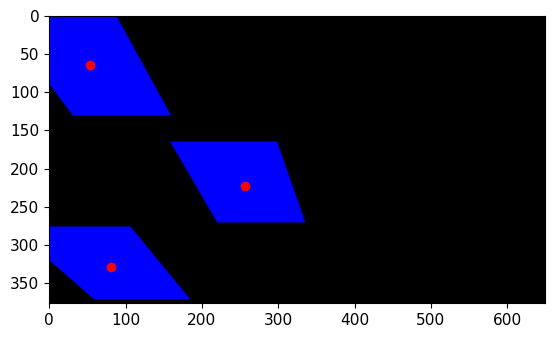

In [11]:
plt.imshow(image_warped_bb)

x, y = bounding_boxes_centres_transformed[0].T
plt.scatter(x, y, color= 'red')
plt.show()

## <span style='color:#ff5f27'> 👩🏻‍🔬 Finding a vector of movement</span>

In [12]:
# manually shift centres
bounding_boxes_centres_transformed_shifted = bounding_boxes_centres_transformed.copy()
bounding_boxes_centres_transformed_shifted[0][:,1] += 20

bounding_boxes_centres_transformed_shifted

array([[[     52.924,      84.532],
        [     256.42,      243.31],
        [     80.847,      349.37]]])

In [13]:
directions = [
    get_direction(coords[0], coords[1]) 
    for coords 
    in zip(
        bounding_boxes_centres_transformed[0],
        bounding_boxes_centres_transformed_shifted[0])
]
directions

[[0.0, -1.0], [0.0, -1.0], [0.0, -1.0]]

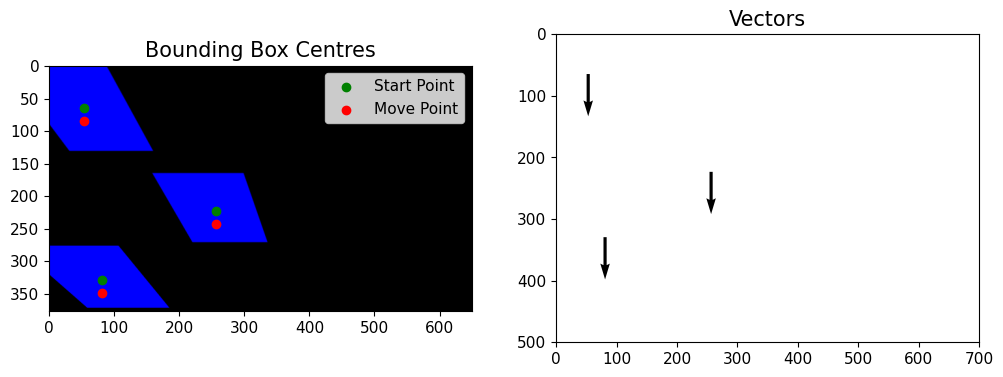

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

ax[0].imshow(image_warped_bb)

x1, y1 = bounding_boxes_centres_transformed[0].T
ax[0].scatter(x1, y1, color='green', label='Start Point')

x2, y2 = bounding_boxes_centres_transformed_shifted[0].T
ax[0].scatter(x2, y2, color= 'red', label='Move Point')


for coords, direction in zip(bounding_boxes_centres_transformed[0], directions):
    ax[1].quiver(
        *coords,
        *direction,
        scale = 10
    )

ax[1].set_xticks(np.arange(0, 800, 100))
ax[1].set_yticks(np.arange(0, 550, 100))
ax[1].invert_yaxis()

ax[0].set_title('Bounding Box Centres', fontsize=15)
ax[1].set_title('Vectors', fontsize=15)
ax[0].legend()

plt.show()

## <span style='color:#ff5f27'> 👷🏿‍♂️ Finding an angle between x-axis and vector</span>

In [15]:
angles = [
    get_vector_angle(coords[0], coords[1])
    for coords 
    in zip(
        bounding_boxes_centres_transformed[0],
        bounding_boxes_centres_transformed_shifted[0]
    )
]
angles

[90, 90, 90]

In [16]:
get_vector_angle([100,100],[200,200])

45

## <span style='color:#ff5f27'> 🔮 Building normalized bounding boxes</span>

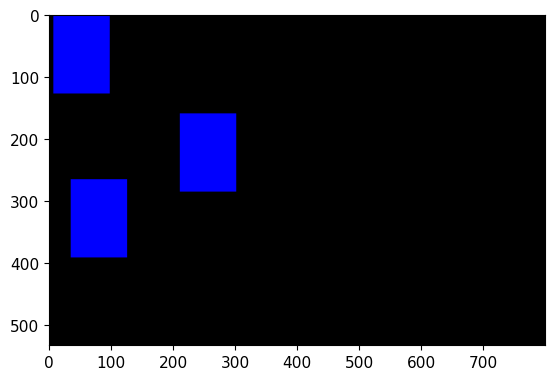

In [17]:
# Filter labels
labels_filtered = labels[mask]

# Create a blank image to draw the rectangle on
image_normalized = np.zeros_like(image)

for centre, angle, label in zip(bounding_boxes_centres_transformed[0], angles, labels_filtered):
    image_normalized = plot_normalized_bounding_box(image_normalized,centre,angle,label)

plt.imshow(image_normalized)
plt.show()

---
## <span style='color:#ff5f27'> 🚀 Wrap Up Function</span>

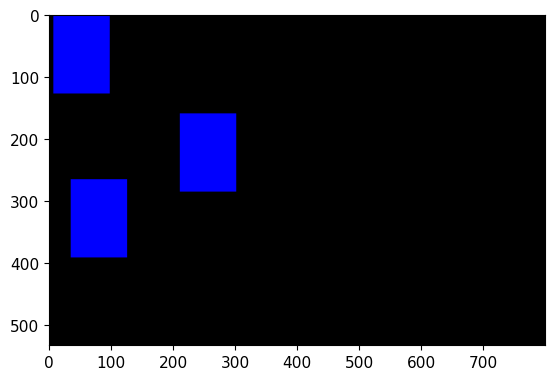

In [18]:
image_normalized = bird_view_transformation(
    image,
    points1,
    bounding_boxes, # Predicted Bounding Boxes
    labels, # Predicted Labels
    bounding_boxes_centres_transformed_shifted, # BoundingBox Centres from previous frame
)

plt.imshow(image_normalized)
plt.show()

---